## Imports

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem
import rdkit.Chem.Lipinski as l
import rdkit.Chem.Fragments as f
from rdkit.Chem import Descriptors
import rdkit.Chem.rdMolDescriptors as d

from sklearn import metrics
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import KBinsDiscretizer

## Extract features from SMILES

In [11]:
def binaryToInt(list):
  return int("".join(str(i) for i in list),2)

def aromaticAtoms(m):
  aromatic_atoms = [m.GetAtomWithIdx(i).GetIsAromatic() for i in range(m.GetNumAtoms())]
  return np.sum([1 if i == True else 0 for i in aromatic_atoms])

# Append all feature values to a list
def getFeatureValsForM(m):
  features = []
  features.append(m.GetNumAtoms())
  features.append(d.CalcExactMolWt(m))
  features.append(f.fr_Al_COO(m))
  features.append(l.HeavyAtomCount(m))
  features.append(Descriptors.MolLogP(m))
  features.append(Descriptors.MolWt(m))
  features.append(Descriptors.NumRotatableBonds(m))
  features.append(aromaticAtoms(m))
  features.append(aromaticAtoms(m)/Descriptors.HeavyAtomCount(m))
  fp = AllChem.GetMorganFingerprintAsBitVect(m,2,nBits=124)
  features.append(binaryToInt(fp))
  return features

# Extract features and add it to DF
def extractFeatures(raw_data):
  data = []
  for smile in raw_data['SMILES']:
    m = Chem.MolFromSmiles(smile)
    feature_vals = getFeatureValsForM(m)
    columns = ['x' + str(i + 1) for i in range(len(feature_vals))]
    data.append(dict(zip(columns, feature_vals)))
  return pd.DataFrame(data)

def plotROCAUC(model, X, y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
  model.fit(X_train, y_train)
  probs = model.predict_proba(X_test)
  preds = probs[:,1]
  fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
  roc_auc = metrics.auc(fpr, tpr)

  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()
  print('AUC score on train/test split: ' + str(roc_auc))

def testModel(model, X, y):
  strat_k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
  score = cross_val_score(model, X, y, cv=strat_k_fold, scoring='roc_auc')
  print(str(score) + ' Average AUC: ' + str(round(np.mean(score), 4)) + ', STD: ' + str(round(np.std(score), 4)))
  plotROCAUC(model, X, y)
  
def tuneModel(model, params_grid, X, y):
  print('Vanilla model')
  testModel(model, X, y)

  strat_k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
  grid_search = GridSearchCV(model, param_grid=params_grid, cv=strat_k_fold, scoring='roc_auc')
  grid_search.fit(X, y)
  best_params = grid_search.best_params_
  model.set_params(**best_params)
  
  print('Tuned model with params: ' + str(best_params))
  testModel(model, X, y)


## Read the splitted training data (new_training_smiles.csv)

In [12]:
raw_data = pd.read_csv('new_training_smiles.csv')
raw_data.drop('Unnamed: 0', axis=1, inplace=True)
display(raw_data)

,SMILES,ACTIVE
0,C=C(C)c1cccc(C(C)(C)NC(=O)Nc2cc(C)ccc2OC)c1,0.0
1,CCOC(=O)c1cnn2c(C(F)(F)F)cc(-c3cn(C)nc3C)nc12,0.0
2,COc1ccccc1-n1cnc2cc(NC(=O)c3ccco3)ccc21,0.0
3,COc1c(CO)cc(CO)cc(CO)c1=O,0.0
4,COC(=O)CN1C(=S)N(c2ccc(OC)cc2)C(=O)/C1=C/c1cccs1,0.0
...,...,...
133704,c1ccc(Cn2ccnc2-c2ccco2)cc1,0.0
133705,CCOC(=O)c1cnc2c(-c3ccc(Cl)cc3)cnn2c1C,0.0
133706,COc1cc(C(=O)Oc2cccc(C)c2)cc(OC)c1OC,0.0
133707,CC(=O)Nc1cc2c(cc1C(=O)C(C)C)OCCO2,0.0


## Transform data (extract features)

In [13]:
y = [int(label) for label in raw_data['ACTIVE'].values]
raw_data.drop(['ACTIVE'], axis=1, inplace=True)
X = extractFeatures(raw_data)
display(X)

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
0,25,338.199428,0,25,5.09352,338.451,5,12,0.480000,5671210215184166703700378702203336722
1,25,353.109959,0,25,2.63372,353.304,3,14,0.560000,4476816478950354051105503996738056205
2,25,333.111341,0,25,3.87940,333.347,4,20,0.800000,523695094110335032410745669696142338
3,16,226.084124,0,16,-0.46770,226.228,4,7,0.437500,21357387526891337304840442166116352
4,26,388.055149,0,26,2.90430,388.470,5,11,0.423077,9660721225630434155249162382398199314
...,...,...,...,...,...,...,...,...,...,...
133704,17,224.094963,0,17,3.19140,224.263,3,16,0.941176,607503884757588786199083587247138058
133705,22,315.077454,0,22,3.53482,315.760,3,15,0.681818,623168840203088061610875933794848774
133706,22,302.115424,0,22,3.24002,302.326,5,12,0.545455,1682720011216148433928110003258920962
133707,19,263.115758,0,19,2.25490,263.293,3,6,0.315789,5743091227781309622800876834866108448


## Investigate the correlation of the features

,x1,x2,x3,x4,x5,x6,x7,x8,x9
x1,1.000000,0.963239,-0.025882,0.999994,0.347524,0.962520,0.600804,0.503830,-0.005445
x2,0.963239,1.000000,-0.019944,0.963245,0.341367,0.999994,0.605375,0.448088,-0.045538
x3,-0.025882,-0.019944,1.000000,-0.025880,-0.120934,-0.020056,0.097784,-0.149297,-0.153286
x4,0.999994,0.963245,-0.025880,1.000000,0.347502,0.962525,0.600815,0.503828,-0.005451
x5,0.347524,0.341367,-0.120934,0.347502,1.000000,0.342056,0.137291,0.513783,0.366947
x6,0.962520,0.999994,-0.020056,0.962525,0.342056,1.000000,0.604837,0.447957,-0.045258
x7,0.600804,0.605375,0.097784,0.600815,0.137291,0.604837,1.000000,0.176025,-0.150768
x8,0.503830,0.448088,-0.149297,0.503828,0.513783,0.447957,0.176025,1.000000,0.826325
x9,-0.005445,-0.045538,-0.153286,-0.005451,0.366947,-0.045258,-0.150768,0.826325,1.000000


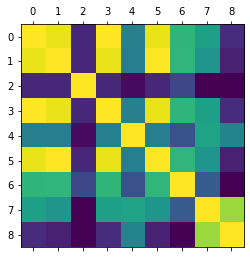

In [14]:
display(X.corr())
plt.matshow(X.corr())
plt.show()

## Conclusions of investigation of correlation of features
x1 and x4 are extremely correlated <br />
x2 and x6 are extremely correlated <br />
x1 and x2, x6 are highly correlated <br />
**Conclusion: Drop x1 and x2**

In [15]:
X.drop(['x1', 'x2'], axis=1, inplace=True)

,x3,x4,x5,x6,x7,x8,x9,x10
0,0,25,5.09352,338.451,5,12,0.480000,5671210215184166703700378702203336722
1,0,25,2.63372,353.304,3,14,0.560000,4476816478950354051105503996738056205
2,0,25,3.87940,333.347,4,20,0.800000,523695094110335032410745669696142338
3,0,16,-0.46770,226.228,4,7,0.437500,21357387526891337304840442166116352
4,0,26,2.90430,388.470,5,11,0.423077,9660721225630434155249162382398199314
...,...,...,...,...,...,...,...,...
133704,0,17,3.19140,224.263,3,16,0.941176,607503884757588786199083587247138058
133705,0,22,3.53482,315.760,3,15,0.681818,623168840203088061610875933794848774
133706,0,22,3.24002,302.326,5,12,0.545455,1682720011216148433928110003258920962
133707,0,19,2.25490,263.293,3,6,0.315789,5743091227781309622800876834866108448


,x3,x4,x5,x6,x7,x8,x9
x3,1.000000,-0.025880,-0.120934,-0.020056,0.097784,-0.149297,-0.153286
x4,-0.025880,1.000000,0.347502,0.962525,0.600815,0.503828,-0.005451
x5,-0.120934,0.347502,1.000000,0.342056,0.137291,0.513783,0.366947
x6,-0.020056,0.962525,0.342056,1.000000,0.604837,0.447957,-0.045258
x7,0.097784,0.600815,0.137291,0.604837,1.000000,0.176025,-0.150768
x8,-0.149297,0.503828,0.513783,0.447957,0.176025,1.000000,0.826325
x9,-0.153286,-0.005451,0.366947,-0.045258,-0.150768,0.826325,1.000000


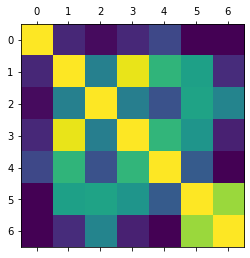

In [16]:
display(X)
display(X.corr())
plt.matshow(X.corr())
plt.show()

## Look at feature importance

[0.00060897 0.04025069 0.253666   0.24648375 0.06535578 0.03294214
 0.05014569 0.31054697]


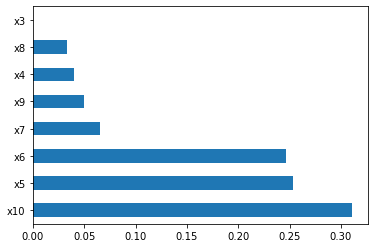

In [17]:
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

## Test vanilla models

### Bernoulli Naive Bayes classifier

StandardScaler
[0.80954261 0.72658066 0.75217703 0.75056547 0.86088632 0.79128557
 0.79851141 0.81793591 0.74732954 0.77109882] Average AUC: 0.7826, STD: 0.0386


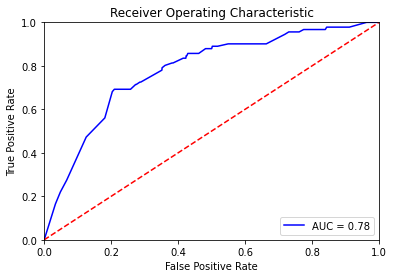

AUC score on train/test split: 0.7789281091167883
MinMaxScaler
[0.5238131  0.52512563 0.51136574 0.52497562 0.52355355 0.53547786
 0.52370059 0.56024723 0.53880388 0.53939078] Average AUC: 0.5306, STD: 0.0127


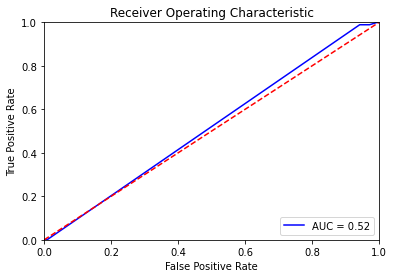

AUC score on train/test split: 0.5190325767462283


C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '


Discretization 2 bins
[0.81146305 0.7317104  0.73558286 0.77307492 0.86701378 0.78223304
 0.80722643 0.82135639 0.75465527 0.77591904] Average AUC: 0.786, STD: 0.0396


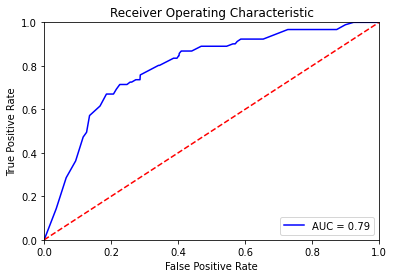

AUC score on train/test split: 0.7941334694941798


C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '


Discretization 4 bins
[0.81695891 0.73060905 0.76567243 0.7775928  0.88402835 0.81819842
 0.81780663 0.82548347 0.74230404 0.77873281] Average AUC: 0.7957, STD: 0.0433


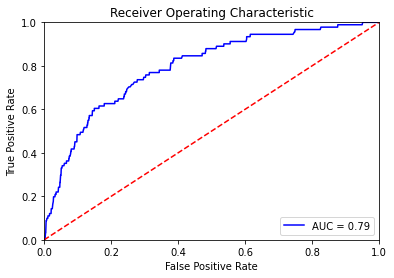

AUC score on train/test split: 0.7942463691631283


C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 5 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '


Discretization 8 bins
[0.80979623 0.73502726 0.77500227 0.7774497  0.88658434 0.81407825
 0.81585263 0.83758541 0.75525726 0.79658459] Average AUC: 0.8003, STD: 0.041


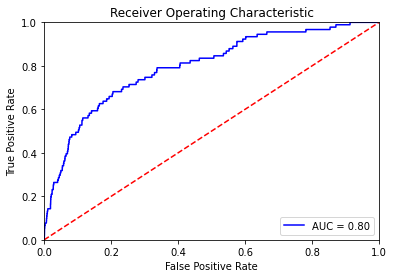

AUC score on train/test split: 0.7965739153308521


C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature

Discretization 16 bins
[0.80682182 0.74687361 0.78402421 0.78310839 0.88504186 0.81751452
 0.82264524 0.84276054 0.77349754 0.81796667] Average AUC: 0.808, STD: 0.037


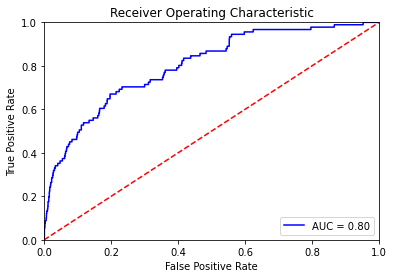

AUC score on train/test split: 0.8016952750582051


In [18]:
X_cop = X.copy()
sc = StandardScaler()
X_cop = sc.fit_transform(X_cop)
print('StandardScaler')
testModel(BernoulliNB(), X_cop, y)

X_cop = X.copy()
sc = MinMaxScaler()
X_cop = sc.fit_transform(X_cop)
print('MinMaxScaler')
testModel(BernoulliNB(), X_cop, y)

X_cop = X.copy()
kbd = KBinsDiscretizer(n_bins=2, encode="onehot")
X_cop = kbd.fit_transform(X_cop)
print('Discretization 2 bins')
testModel(BernoulliNB(), X_cop, y)

X_cop = X.copy()
kbd = KBinsDiscretizer(n_bins=4, encode="onehot")
X_cop = kbd.fit_transform(X_cop)
print('Discretization 4 bins')
testModel(BernoulliNB(), X_cop, y)

X_cop = X.copy()
kbd = KBinsDiscretizer(n_bins=8, encode="onehot")
X_cop = kbd.fit_transform(X_cop)
print('Discretization 8 bins')
testModel(BernoulliNB(), X_cop, y)

X_cop = X.copy()
kbd = KBinsDiscretizer(n_bins=16, encode="onehot")
X_cop = kbd.fit_transform(X_cop)
print('Discretization 16 bins')
testModel(BernoulliNB(), X_cop, y)

Bernoulli Naive Bayes classifier best preprocessing = Discretization 16 bins (Average AUC: 0.81, STD: 0.0274, AUC score on train/test split: 0.801)

### Gaussian Naive Bayes classifier

StandardScaler
[0.81836125 0.74842003 0.77287459 0.78573149 0.86480123 0.82536109
 0.83253266 0.79532383 0.743859   0.79628752] Average AUC: 0.7984, STD: 0.0361


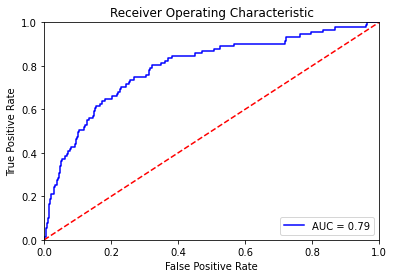

AUC score on train/test split: 0.7933959132627278
MinMaxScaler
[0.81836125 0.74842003 0.77287459 0.78573149 0.86480123 0.82536109
 0.83253266 0.79532383 0.743859   0.79628752] Average AUC: 0.7984, STD: 0.0361


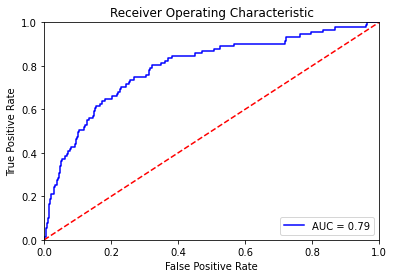

AUC score on train/test split: 0.7933959132627278


In [19]:
X_cop = X.copy()
sc = StandardScaler()
X_cop = sc.fit_transform(X_cop)
print('StandardScaler')
testModel(GaussianNB(), X_cop, y)

X_cop = X.copy()
sc = MinMaxScaler()
X_cop = sc.fit_transform(X_cop)
print('MinMaxScaler')
testModel(GaussianNB(), X_cop, y)

# ---This crashes!---
# X_cop = X.copy()
# kbd = KBinsDiscretizer(n_bins=4, encode="onehot")
# X_cop = kbd.fit_transform(X_cop)
# print('Discretization')
# testModel(GaussianNB(), X_cop, y)

Gaussian Naive Bayes classifier best preprocessing = standard or minmax scaler (Average AUC: 0.7969, STD: 0.0246, AUC score on train/test split: 0.784)

### Multinomial Naive Bayes classifier

MinMaxScaler
[0.79254481 0.74943847 0.75965649 0.78408737 0.85075416 0.79259712
 0.82529497 0.75754065 0.73101926 0.79886344] Average AUC: 0.7842, STD: 0.0344


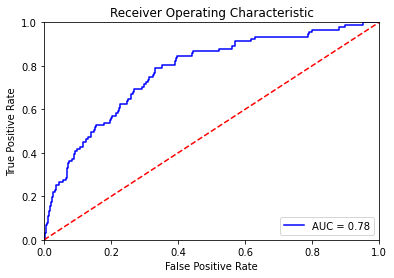

AUC score on train/test split: 0.7750550736122324


C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '


Discretization 2 bins
[0.81146305 0.7317104  0.73558286 0.77307492 0.86701378 0.78223304
 0.80722643 0.82135639 0.75465527 0.77591904] Average AUC: 0.786, STD: 0.0396


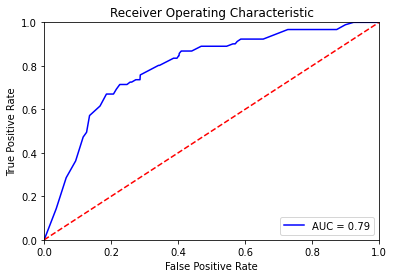

AUC score on train/test split: 0.7941334694941798


C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '


Discretization 4 bins
[0.81695891 0.73060905 0.76567243 0.7775928  0.88402835 0.81819842
 0.81780663 0.82548347 0.74230404 0.77873281] Average AUC: 0.7957, STD: 0.0433


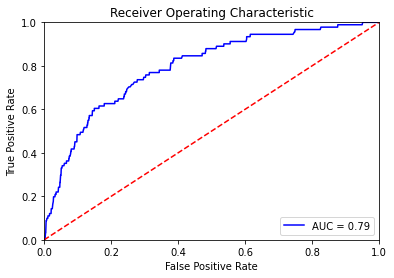

AUC score on train/test split: 0.7942463691631283


C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 5 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '


Discretization 8 bins
[0.80979623 0.73502726 0.77500227 0.7774497  0.88658434 0.81407825
 0.81585263 0.83758541 0.75525726 0.79658459] Average AUC: 0.8003, STD: 0.041


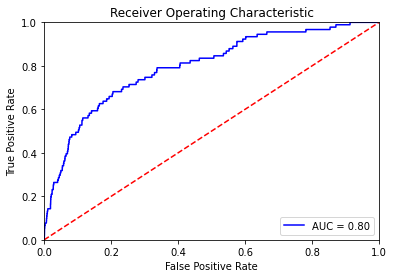

AUC score on train/test split: 0.7965739153308521


C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature

Discretization 16 bins
[0.80682182 0.74687361 0.78402421 0.78310839 0.88504186 0.81751452
 0.82264524 0.84276054 0.77349754 0.81796667] Average AUC: 0.808, STD: 0.037


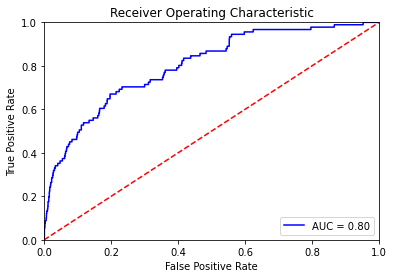

AUC score on train/test split: 0.8016952750582051


C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature

Discretization 32 bins
[0.81662338 0.74873385 0.7816429  0.78980725 0.89240389 0.81847375
 0.82789043 0.83287411 0.77085497 0.82442619] Average AUC: 0.8104, STD: 0.038


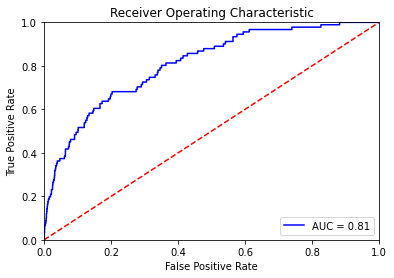

AUC score on train/test split: 0.8097770783675334


In [20]:
# ---This crashes!---
# X_cop = X.copy()
# sc = StandardScaler()
# X_cop = sc.fit_transform(X_cop)
# print('StandardScaler')
# testModel(MultinomialNB(), X_cop, y)

X_cop = X.copy()
sc = MinMaxScaler()
X_cop = sc.fit_transform(X_cop)
print('MinMaxScaler')
testModel(MultinomialNB(), X_cop, y)

X_cop = X.copy()
kbd = KBinsDiscretizer(n_bins=2, encode="onehot")
X_cop = kbd.fit_transform(X_cop)
print('Discretization 2 bins')
testModel(MultinomialNB(), X_cop, y)

X_cop = X.copy()
kbd = KBinsDiscretizer(n_bins=4, encode="onehot")
X_cop = kbd.fit_transform(X_cop)
print('Discretization 4 bins')
testModel(MultinomialNB(), X_cop, y)

X_cop = X.copy()
kbd = KBinsDiscretizer(n_bins=8, encode="onehot")
X_cop = kbd.fit_transform(X_cop)
print('Discretization 8 bins')
testModel(MultinomialNB(), X_cop, y)

X_cop = X.copy()
kbd = KBinsDiscretizer(n_bins=16, encode="onehot")
X_cop = kbd.fit_transform(X_cop)
print('Discretization 16 bins')
testModel(MultinomialNB(), X_cop, y)

X_cop = X.copy()
kbd = KBinsDiscretizer(n_bins=32, encode="onehot")
X_cop = kbd.fit_transform(X_cop)
print('Discretization 32 bins')
testModel(MultinomialNB(), X_cop, y)

Multinomial Naive Bayes classifier best preprocessing = Discretization 16 bins (Average AUC: 0.81, STD: 0.0274, AUC score on train/test split: 0.801)

### Decision Tree classifier

[0.55124997 0.53779206 0.49876247 0.53808615 0.57797234 0.55094404
 0.53786114 0.52489075 0.53684888 0.53789853] Average AUC: 0.5392, STD: 0.0191


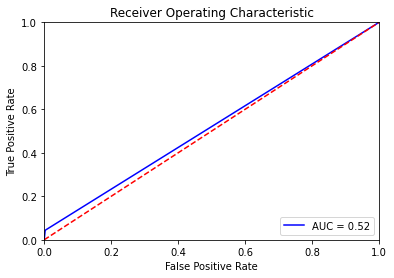

AUC score on train/test split: 0.5204638478778324


In [21]:
# TODO: Investigate if we need to change data to fit model
testModel(DecisionTreeClassifier(), X, y)

### Random Forest classifier

[0.71946042 0.68092722 0.64281344 0.76604448 0.82381862 0.7360388
 0.74168861 0.64870701 0.73707755 0.74604434] Average AUC: 0.7243, STD: 0.0519


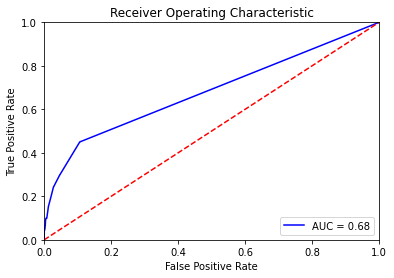

AUC score on train/test split: 0.6796528755463273


In [22]:
testModel(RandomForestClassifier(), X, y)

### Multi-layer Perceptron classifier

StandardScaler
[0.8234969  0.77568123 0.77071335 0.8251805  0.90527658 0.87044314
 0.86060309 0.79621596 0.79657581 0.805774  ] Average AUC: 0.823, STD: 0.0414


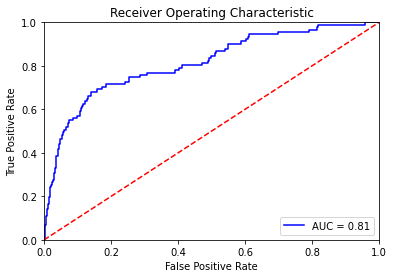

AUC score on train/test split: 0.8136443452758658
MinMaxScaler
[0.79786403 0.74152183 0.76761261 0.79940551 0.86079455 0.80003612
 0.83383927 0.77938198 0.73032496 0.79457419] Average AUC: 0.7905, STD: 0.0371


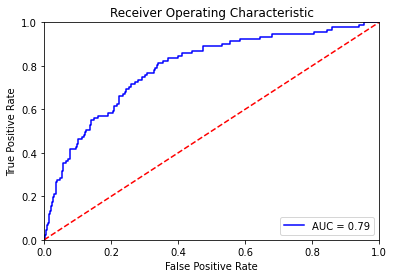

AUC score on train/test split: 0.7899209108976034


C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '


Discretization 2 bins
[0.81146305 0.7317104  0.73558286 0.77307492 0.86701378 0.78223304
 0.80722643 0.82135639 0.75465527 0.77591904] Average AUC: 0.786, STD: 0.0396


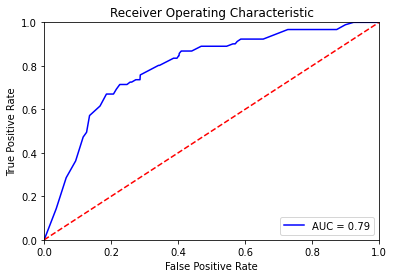

AUC score on train/test split: 0.7941334694941798


C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '


Discretization 4 bins
[0.81695891 0.73060905 0.76567243 0.7775928  0.88402835 0.81819842
 0.81780663 0.82548347 0.74230404 0.77873281] Average AUC: 0.7957, STD: 0.0433


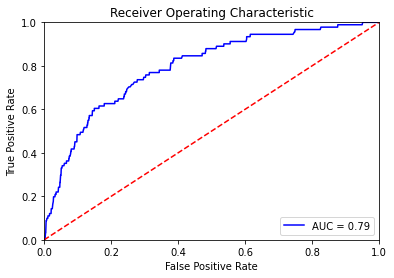

AUC score on train/test split: 0.7942463691631283


C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 5 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '


Discretization 8 bins
[0.80979623 0.73502726 0.77500227 0.7774497  0.88658434 0.81407825
 0.81585263 0.83758541 0.75525726 0.79658459] Average AUC: 0.8003, STD: 0.041


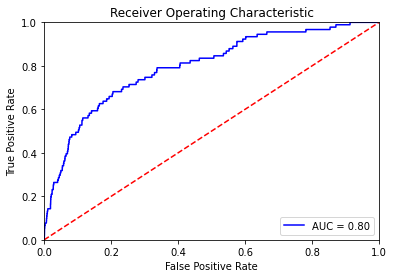

AUC score on train/test split: 0.7965739153308521


C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature

Discretization 16 bins
[0.80682182 0.74687361 0.78402421 0.78310839 0.88504186 0.81751452
 0.82264524 0.84276054 0.77349754 0.81796667] Average AUC: 0.808, STD: 0.037


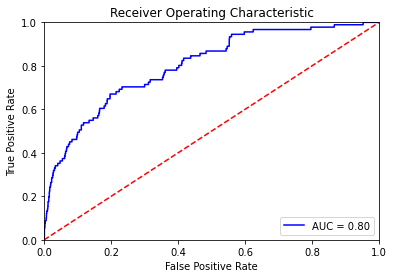

AUC score on train/test split: 0.8016952750582051


C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature

Discretization 32 bins
[0.81662338 0.74873385 0.7816429  0.78980725 0.89240389 0.81847375
 0.82789043 0.83287411 0.77085497 0.82442619] Average AUC: 0.8104, STD: 0.038


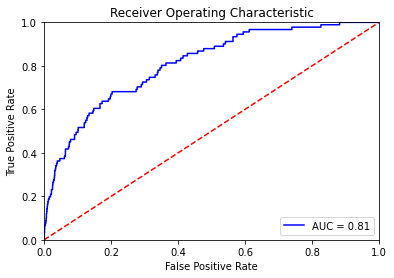

AUC score on train/test split: 0.8097770783675334


In [23]:
X_cop = X.copy()
sc = StandardScaler()
X_cop = sc.fit_transform(X_cop)
print('StandardScaler')
testModel(MLPClassifier(), X_cop, y)

X_cop = X.copy()
sc = MinMaxScaler()
X_cop = sc.fit_transform(X_cop)
print('MinMaxScaler')
testModel(MLPClassifier(), X_cop, y)

X_cop = X.copy()
kbd = KBinsDiscretizer(n_bins=2, encode="onehot")
X_cop = kbd.fit_transform(X_cop)
print('Discretization 2 bins')
testModel(MLPClassifier(), X_cop, y)

X_cop = X.copy()
kbd = KBinsDiscretizer(n_bins=4, encode="onehot")
X_cop = kbd.fit_transform(X_cop)
print('Discretization 4 bins')
testModel(MLPClassifier(), X_cop, y)

X_cop = X.copy()
kbd = KBinsDiscretizer(n_bins=8, encode="onehot")
X_cop = kbd.fit_transform(X_cop)
print('Discretization 8 bins')
testModel(MLPClassifier(), X_cop, y)

X_cop = X.copy()
kbd = KBinsDiscretizer(n_bins=16, encode="onehot")
X_cop = kbd.fit_transform(X_cop)
print('Discretization 16 bins')
testModel(MLPClassifier(), X_cop, y)

X_cop = X.copy()
kbd = KBinsDiscretizer(n_bins=32, encode="onehot")
X_cop = kbd.fit_transform(X_cop)
print('Discretization 32 bins')
testModel(MLPClassifier(), X_cop, y)

## Conclusions of vanilla models:

| Model      | Kfold AUC Score | Kfold std | Train/test AUC Score | Best Preprocessing |
| ----------- | ----------- | ----------- | ----------- | ----------- |
| Bernoulli Naive Bayes      | 0.81       | 0.0274       | 0.801       | Discretization 16 bins       |
| Gaussian Naive Bayes   | 0.7969        | 0.0246       | 0.784       | Standard Scaler       |
| Multinomial Naive Bayes      | 0.81       | 0.0274       | 0.801       | Discretization 16 bins       |
| Decision Tree   | 0.5339        | 0.023       | 0.536       | No Preprocessing       |
| Random Forest   | 0.7131        | 0.0407       | 0.732       | No Preprocessing       |
| Multi-layer Perceptron   | 0.824        | 0.0227       | 0.812       | Standard Scaler      |

We want to find the best parameters for the following models: Multi-layer Perceptron, Multinomial Naive Bayes and Random Forest

## Find best parameters

### Multi-layer Perceptron classifier

Vanilla model
[0.78535875 0.86121441 0.83580706 0.80930869 0.80497966 0.80955606
 0.86793612 0.82188545 0.84688192 0.79037679] Average AUC: 0.8233, STD: 0.0272


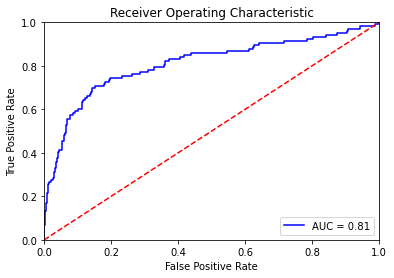

AUC score on train/test split: 0.8098763728527176


C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Tuned model with params: {'activation': 'relu', 'alpha': 0.005, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}
[0.79911852 0.8628844  0.84966192 0.81510822 0.80400587 0.79875803
 0.85413231 0.83376329 0.85411268 0.80294178] Average AUC: 0.8274, STD: 0.0248


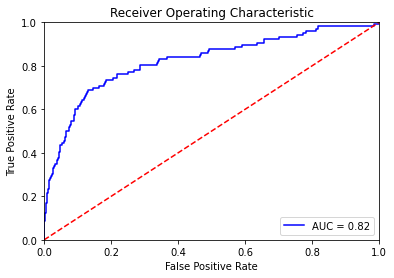

AUC score on train/test split: 0.8226896648831314


In [7]:
params = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.005],
    'learning_rate': ['adaptive']
}

X_cop = X.copy()
sc = StandardScaler()
X_cop = sc.fit_transform(X_cop)
tuneModel(MLPClassifier(), params, X_cop, y)

Multi-layer Perceptron best params = {'activation': 'relu', 'alpha': 0.005, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}

### Multinomial Naive Bayes classifier

C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature

Vanilla model
[0.77841479 0.82597522 0.79014218 0.80987706 0.82132003 0.81277093
 0.85808144 0.78279166 0.8466532  0.77351812] Average AUC: 0.81, STD: 0.0274


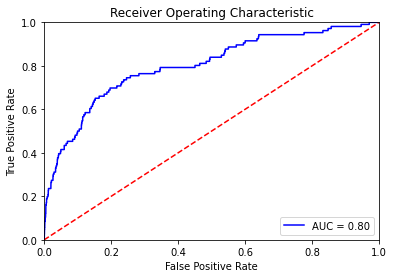

AUC score on train/test split: 0.8005304139678964
Tuned model with params: {'alpha': 0.1}
[0.77899441 0.82732001 0.79124554 0.81057206 0.82140052 0.81268847
 0.85812464 0.78423664 0.84646669 0.77265427] Average AUC: 0.8104, STD: 0.0273


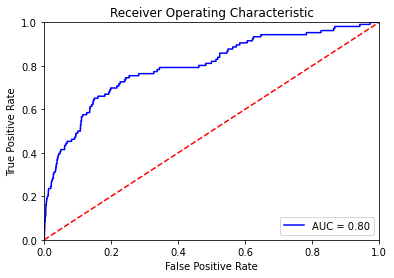

AUC score on train/test split: 0.8000792734441002


In [63]:
params = {
    'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]
}

X_cop = X.copy()
kbd = KBinsDiscretizer(n_bins=16, encode="onehot")
X_cop = kbd.fit_transform(X_cop)
tuneModel(MultinomialNB(), params, X_cop, y)

Guassian Naive Bayes best params = default

### Random Forest classifier

Vanilla model
[0.65066685 0.76485779 0.69646237 0.67708481 0.73533333 0.62505988
 0.78999592 0.70483281 0.72711308 0.70825971] Average AUC: 0.708, STD: 0.0473


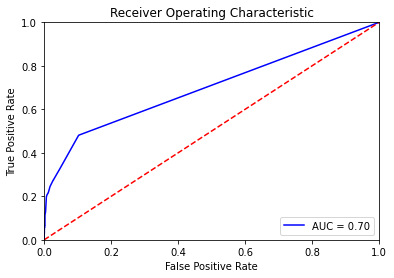

AUC score on train/test split: 0.6984867642917489


KeyboardInterrupt: 

In [9]:
params = {
    'n_estimators': [50, 100, 400],
    'class_weight': ['balanced_subsample', None],
    'oob_score': [True],
    'min_samples_split': [2, 4, 6],
    'max_depth': [4, 8, 16],
    'ccp_alpha': [0.0, 0.05]
}

tuneModel(RandomForestClassifier(), params, X, y)